In [1]:
#User inputs
import os.path

#project locations (shapefile with location of elements to evaluate)
data_folder=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
#data_folder=os.path.join(os.pardir,'dataset')
project_location_path=os.path.join(data_folder,'Mozambique_PPIS/EIB_locations_few.shp')
project_id='Name' #name of column used as id

#study boundary (optional)
study_area_path=os.path.join(data_folder,'Mozambique_PPIS/mozambique.shp')

#study boundary (optional)
#study_area_path=os.path.join(data_folder,'timor/boundaries.shp')
#area_sq=os.path.join(data_folder,'timor/timor_.shp')
#output folder
out_path=r'\\COWI.net\projects\A245000\A248363\CRVA\Scripts\outputs'
out_path_database=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
#projection CRS (default = 'EPSG:4326')
bCRS='EPSG:4326'

#buffer for climate/grid variables
buffer=10000 #buffer in meters, 0 = no buffer is computed

mCRS='EPSG:31983' #metric CRS for buffer in meters (find relevant metric CRS for location!)

In [2]:
#Import python packages
from rasterstats import zonal_stats
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
import rioxarray #used when calling ncdata.rio.write_crs
import xarray as xr
import os
import os.path
import matplotlib.pyplot as plt
import netCDF4 as nc#not directly used but needs to be imported for some nc4 files manipulations, use for nc files
from netCDF4 import Dataset
import csv #REMOVE ? not in use ?
import numpy as np
import numpy.ma as ma
from mpl_toolkits.basemap import Basemap
import shutil # to move folders
import warnings
warnings.filterwarnings('ignore') # to ignore the warnings
#import io
import cdsapi # for copernicus function
import datetime # to have actual date
from osgeo import gdal, ogr, osr # in order to convert shp in raster
from geopandas import GeoDataFrame
from shapely.geometry import Point
from matplotlib.lines import Line2D
import seaborn as sns

import sys 
sys.path.append("../0-Functions")

from FunctionsAndClass import read_cckp_ncdata
from FunctionsAndClass import get_cckp_file_name

from Functions_Indicators import temporal_avg
from Functions_Indicators import temporal_max
from Functions_Indicators import df_stat_distr
from Functions_Indicators import number_day_above_threshold
from Functions_Indicators import filter_dataframe
from Functions_Indicators import changes_in_indicators
from Functions_Indicators import dataframe_n_day_event
from Functions_Indicators import dataframe_max_5_days_event
from Functions_Indicators import level_exposure
from Functions_Indicators import vulnerability
from Functions_Indicators import dataframe_threshold_coresponding_to_return_period_model
from Functions_Indicators import dataframe_return_period_coresponding_to_past_100year_event_model
from Functions_ImportData import add_year_month_season

from Functions_ImportData import import_treat_modeled_NEX_GDDP_CMIP6
from Functions_ImportData import sensitivity
from Functions_ImportData import import_BC_NOAA_NEX_GDDP_CMIP6

from Graphs_functions import plot_lines
from Graphs_functions import trends_month

from Functions_likelihood import likelihood_accross_models
from Functions_likelihood import likelihood_accross_models_and_ssps

from Functions_likelihood import look_best_distr
from Functions_likelihood import range_likelihood

In [4]:
#PATHS DATA INPUT
#precipitation 
path_pr=r'\\cowi.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file\pr\pr_mm_per_day_day_1950-2100\pr_1950-2100_projectsMoz.csv'
df_pr=pd.read_csv(path_pr)
#\\cowi.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file\pr\pr_mm_per_day_day_1950-2100\pr_1950-2100_projectsMoz.csv 
#\\cowi.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_mutuaSyst_ChicambaSyst\pr\pr_mm\day_day_1980-2080\pr_1980-2080mz_new.csv'

#tas: daily mean temperature 
# path_tas=r'\\cowi.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_mutuaSyst_ChicambaSyst\tas\tas_Celsius_day_1980-2080\tas_1980-2080mz_new.csv'
# df_tas=pd.read_csv(path_tas) 
# # \\cowi.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file\tas\tas_Celsius_day_1950-2100\tas_1950-2100_projectsMoz.csv
# \\cowi.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_mutuaSyst_ChicambaSyst\tas\tas_Celsius_day_1980-2080\tas_1980-2080mz_new.csv
 

#tasmin: minimum daily temperature 
# path_tasmin=r'\\cowi.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file\tasmin\tasmin_Celsius_day_1950-2100\tasmin_1950-2100_projectsMoz.csv'
# df_tasmin=pd.read_csv(path_tasmin)
#tasmax: maximum daily temperature 
# path_tasmax=r'\\cowi.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_mutuaSyst_ChicambaSyst\tasmax\tasmax_Celsius_day_1980-2080\tasmax_1980-2080mz_new.csv'
# df_tasmax=pd.read_csv(path_tasmax)
#\\cowi.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file\tasmax\tasmax_Celsius_day_1950-2100\tasmax_1950-2100_projectsMoz.csv
#\\cowi.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_mutuaSyst_ChicambaSyst\tasmax\tasmax_Celsius_day_1980-2080\tasmax_1980-2080mz_new.csv


#rs: radiaion (MJ.m-2.day-1)
# path_rs=r'\\cowi.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file\rsds\rsds_MJ.m-2.day-1_day_1950-2100\rsds_1950-2100_projectsMoz.csv'
# df_rs=pd.read_csv(path_rs)
# near surface relative humidity RH 
# path_RH=r'\\cowi.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file\hurs\hurs_%_day_1950-2100\hurs_1950-2100_projectsMoz.csv'
# df_RH=pd.read_csv(path_RH)
# Daily-Mean Near-Surface Wind Speed [m_s-1]
# path_wind10=r'\\cowi.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file\sfcWind\sfcWind_m_s-1_day_1950-2100\sfcWind_1950-2100_projectsMoz.csv'
# df_wind10=pd.read_csv(path_wind10)

def filter_data(df,loc,mod_excl): # Filter data by location, models, and time period
    df = df[df['Name project']==loc]
    df = df[~df['Model'].isin(mod_excl)]
    df=add_year_month_season(df,'Date')
    return df


In [4]:
df_tasmax['Name project'].unique()

array(['Dondo_DC', 'Manga_DC', 'Munhava_reservoir', 'Manica', 'Chimoio',
       'Gondola', 'ChicambaDam'], dtype=object)

<a id='NEXGDDPCMIP6_Temperature'></a>
# NEX-GDDP-CMIP6 Temperature 

By comparing NEX GDDP CMIP6 data to observed data, we know that the models 'TAIESM1' and 'CMCC-CM2-SR5' do not comply to the observed data. We are taking them off the analysis.
A bias correction does not better the quality of the data. It follows oberved data enough. The data use below were not bias corrected a second time.

## TAS (all days - no aggregation)

In [ ]:
df_tasmax['Name project'].unique()

In [7]:
# ______________CHANGE INPUT _______________________________________________#
loc='Manga_DC'
yr_past=np.array([1984, 2014]) # set periods
yr_future=np.array([2030,2060])
mod_excl=['CMCC-CM2-SR5','TaiESM1']# 

#______________________________________________________________________#

df_tas_filt= filter_data(df_tas,loc,mod_excl)#'TaiESM1','CMCC-CM2-SR5','NESM3'
#Past and future - seperated
df_tas_future=df_tas_filt.reset_index()[df_tas_filt.reset_index()['Year'].between(yr_future[0],yr_future[1])][['Name project','Daily Near-Surface Air Temperature °C ','Model','Experiment']]
df_tas_past=df_tas_filt.reset_index()[df_tas_filt.reset_index()['Year'].between(yr_past[0],yr_past[1])][['Name project','Daily Near-Surface Air Temperature °C ','Model','Experiment']]

df_perc_future=df_tas_future.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1,.5,.9,.95,.975,.99])
df_perc_past=df_tas_past.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1,.5,.9,.95,.975,.99])

#Future scenarios quantiles: 
idx=pd.IndexSlice
#scenarios=list(df_tas_NEXGDDPCMIP6_loc_future.Experiment.unique())
scenarios=['ssp126', 'ssp245', 'ssp370', 'ssp585']
model_quant=['1%','10%','50%','90%','95%','97.5%','99%']
result=pd.DataFrame() #initialize dataframe

#Modelled historical percentiles
df_hist=df_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
#print(df_hist)
df_hist.columns=df_hist.columns.droplevel(0)
df_hist=df_hist[model_quant]
dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
df_hist.rename(columns=dict,inplace=True)
#print(df_hist)
df_hist_perc=df_hist.describe(percentiles=[.1,.5,.9,.95,.975,.99])
#print(df_hist_perc)
dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
df_hist_perc.rename(index=dict,inplace=True)
#print(df_hist_perc)
df_hist_perc=df_hist_perc.reset_index()
df_hist_perc=df_hist_perc[df_hist_perc['index'].isin(['p10 model','p50 model','p90 model'])]
df_hist_perc['Experiment']='historical'
result=pd.concat([result,df_hist_perc])


for s in scenarios: 
    df_future=df_perc_future.loc[idx[s,:],:].droplevel('Experiment')
    df_past=df_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
    diff=(df_future-df_past)
    diff.columns=diff.columns.droplevel(0) # remove header to refer to temperature
    diff=diff[model_quant]
    dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
    diff.rename(columns=dict,inplace=True)
    diff_perc=diff.describe(percentiles=[.1,.5,.9,.95,.975,.99])
    dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
    diff_perc.rename(index=dict,inplace=True)
    diff_perc=diff_perc.reset_index()
    diff_perc=diff_perc[diff_perc['index'].isin(['p10 model','p50 model','p90 model'])]
    diff_perc['Experiment']=s
    result=pd.concat([result,diff_perc])

print(result)
name='tas_'+loc+ '_'+ str(yr_future[0]) +str(yr_future[1]) +'_'+ str(yr_past[0]) +str(yr_past[1]) +'_.xlsx'
result.to_excel(name)  


In [ ]:
#  p=sns.lineplot(df_tas_filt,x='Year',y='Daily Near-Surface Air Temperature °C ',hue='Model')

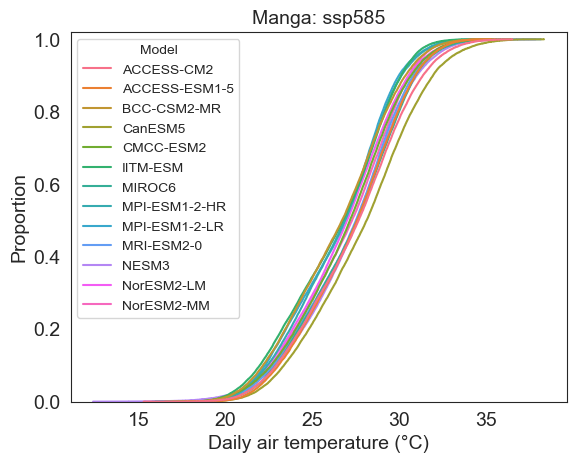

In [18]:
#USE THIS ONE
# CDF-curves for Models with different scenarios 
var='Daily mean '
scenario='ssp585' #'ssp126', ssp245', 'ssp370','ssp585' 'historical'
loc_= loc.replace('_','') # take off every - of project names historical
loc_=loc_.replace('WTP','')
loc_=loc_.replace('EIB','')

df_scen=df_tas_filt[df_tas_filt['Experiment']==scenario]

f, ax = plt.subplots()
#for m in models:
ax = sns.ecdfplot(x=df_scen['Daily Near-Surface Air Temperature °C '], hue=df_scen['Model'])
ax.grid(False)
sns.set_context( rc={"axes.titlesize":14,"axes.labelsize":14})  
ylim_min=0#df[y_axis].min()
ylim_max=1.02#df[y_axis].max()
ax.set_ylim(ylim_min,ylim_max)
ax.tick_params(labelsize=14)
plt.xlabel('Daily air temperature (°C)')
sns.set_style("white")
sns.set_style(rc = {'axes.facecolor': 'white'})
title=loc_': ' + scenario
plt.title(title)
f.tight_layout#
f.savefig(loc+'_tas_'+scenario+ '.svg', bbox_inches='tight')



## TASMAX: all days - no aggregation

In [21]:
#_____________CAHNGE INPUT ___________________________# 
loc='Manga_DC' 
yr_past=np.array([1984, 2014]) # set periods
yr_future=np.array([2030,2060])
mod_excl=['TaiESM1']# 
#_______________________________________________________# 

df_tasmax_filt= filter_data(df_tasmax,loc,mod_excl)#'TaiESM1','CMCC-CM2-SR5','NESM3'
#Past and future - seperated
df_tasmax_future=df_tasmax_filt.reset_index()[df_tasmax_filt.reset_index()['Year'].between(yr_future[0],yr_future[1])][['Name project','Daily Maximum Near-Surface Air Temperature °C ','Model','Experiment']]
df_tasmax_past=df_tasmax_filt.reset_index()[df_tasmax_filt.reset_index()['Year'].between(yr_past[0],yr_past[1])][['Name project','Daily Maximum Near-Surface Air Temperature °C ' ,'Model','Experiment']]

df_perc_future=df_tasmax_future.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
df_perc_past=df_tasmax_past.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])

#Future scenarios quantiles: 
idx=pd.IndexSlice
scenarios=['ssp126', 'ssp245', 'ssp370',  'ssp585']
#scenarios=list(df_tasmax_NEXGDDPCMIP6_loc_future.Experiment.unique())
model_quant=['1%','10%','50%','90%','95%','97.5%','99%']
result=pd.DataFrame() #initialize dataframe

df_hist=df_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
#print(df_hist)
df_hist.columns=df_hist.columns.droplevel(0)
df_hist=df_hist[model_quant]
dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
df_hist.rename(columns=dict,inplace=True)
#print(df_hist)
df_hist_perc=df_hist.describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
#print(df_hist_perc)
dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
df_hist_perc.rename(index=dict,inplace=True)
#print(df_hist_perc)
df_hist_perc=df_hist_perc.reset_index()
df_hist_perc=df_hist_perc[df_hist_perc['index'].isin(['p10 model','p50 model','p90 model'])]
df_hist_perc['Experiment']='historical'
result=pd.concat([result,df_hist_perc])
for s in scenarios: 
    df_future=df_perc_future.loc[idx[s,:],:].droplevel('Experiment')
    df_past=df_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
    diff=(df_future-df_past)
    diff.columns=diff.columns.droplevel(0) # remove header to refer to temperature
    diff=diff[model_quant]
    dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
    diff.rename(columns=dict,inplace=True)
    diff_perc=diff.describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
    dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
    diff_perc.rename(index=dict,inplace=True)
    diff_perc=diff_perc.reset_index()
    diff_perc=diff_perc[diff_perc['index'].isin(['p10 model','p50 model','p90 model'])]
    diff_perc['Experiment']=s
    result=pd.concat([result,diff_perc])

print(result)
name='tasmax_'+loc+ '_'+ str(yr_future[0]) +str(yr_future[1]) +'_'+ str(yr_past[0]) +str(yr_past[1]) +'_.xlsx'
result.to_excel(name)  

In [ ]:
#p=sns.lineplot(df_tasmax_filt,x='Year',y='Daily Maximum Near-Surface Air Temperature °C ',hue='Model')

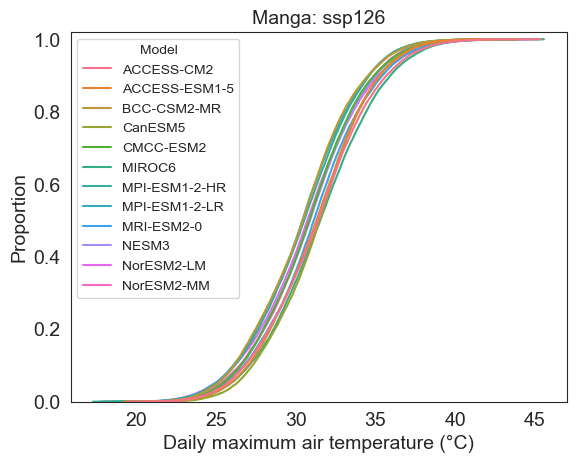

In [28]:
#USE THIS ONE
# CDF-curves for Models with different scenarios 
var='Daily max '
scenario='ssp370' #'ssp126', ssp245', 'ssp370','ssp585' 'historical'
loc_= loc.replace('_','') # take off every - of project names
loc_=loc_.replace('WTP','')
loc_=loc_.replace('EIB','')

df_tas_scen=df_tasmax_filt[df_tasmax_filt['Experiment']==scenario]

f, ax = plt.subplots()
#for m in models:
ax = sns.ecdfplot(x=df_tas_scen['Daily Maximum Near-Surface Air Temperature °C '], hue=df_tas_scen['Model'])
ax.grid(False)
sns.set_context( rc={"axes.titlesize":14,"axes.labelsize":14})  
ylim_min=0#df[y_axis].min()
ylim_max=1.02#df[y_axis].max()
ax.set_ylim(ylim_min,ylim_max)
ax.tick_params(labelsize=14)
plt.xlabel('Daily maximum air temperature (°C)')
sns.set_style("white")
sns.set_style(rc = {'axes.facecolor': 'white'})
title=loc_+ ': ' + scenario
plt.title(title)
f.tight_layout#
f.savefig(loc+'_tasmax_'+scenario+ '.svg', bbox_inches='tight')

## TASMAX: yearly aggregation on 90th percentile
#### Taxmax- yearly aggregation 90th quantiles: All models treated together  - differentiating the scenario

In [ ]:
df_tasmax_yrp90_ = df_tasmax_filt.groupby(['Name project','Experiment','Model','Year']).quantile([0.9])
df_tasmax_yrp90=df_tasmax_yrp90_.reset_index()
# df_tasmax_yrp90_loc = df_tasmax_NEXGDDPCMIP6_loc.groupby(['Name project','Experiment','Model','Year']).quantile([0.9])
# df_tasmax_yrp90_loc=df_tasmax_yrp90_loc.reset_index()

#Past and future - seperated
df_tasmax_yrp90_future=df_tasmax_yrp90.reset_index()[df_tasmax_yrp90.reset_index()['Year'].between(yr_future[0],yr_future[1])][['Name project','Daily Maximum Near-Surface Air Temperature °C ','Model','Experiment']]
df_tasmax_yrp90_past=df_tasmax_yrp90.reset_index()[df_tasmax_yrp90.reset_index()['Year'].between(yr_past[0],yr_past[1])][['Name project','Daily Maximum Near-Surface Air Temperature °C ','Model','Experiment']]
#Finding percentiles of the maximum temperature aggregated per year 
df_perc_future=df_tasmax_yrp90_future.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
df_perc_past=df_tasmax_yrp90_past.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])

#Future scenarios quantiles: 
idx=pd.IndexSlice
scenarios=['ssp126', 'ssp245', 'ssp370',  'ssp585']
model_quant=['1%','10%','50%','90%','95%','97.5%','99%']
result=pd.DataFrame() #initialize dataframe


df_hist=df_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
#print(df_hist)
df_hist.columns=df_hist.columns.droplevel(0)
df_hist=df_hist[model_quant]
dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
df_hist.rename(columns=dict,inplace=True)
#print(df_hist)
df_hist_perc=df_hist.describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
#print(df_hist_perc)
dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
df_hist_perc.rename(index=dict,inplace=True)
#print(df_hist_perc)
df_hist_perc=df_hist_perc.reset_index()
df_hist_perc=df_hist_perc[df_hist_perc['index'].isin(['p10 model','p50 model','p90 model'])]
df_hist_perc['Experiment']='historical'
result=pd.concat([result,df_hist_perc])

for s in scenarios: 
    df_future=df_perc_future.loc[idx[s,:],:] 
    df_past=df_perc_past.loc[idx['historical',:],:]
  #  print(df_future)
    df_future=df_future.reset_index().set_index(['Experiment','Model']).droplevel('Experiment')
    df_past=df_past.reset_index().set_index(['Experiment','Model']).droplevel('Experiment')
    diff=(df_future-df_past)
    diff.columns=diff.columns.droplevel(0) # remove header to refer to temperature
    diff=diff[model_quant]
    dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
    diff.rename(columns=dict,inplace=True)
  #  print(diff)
    diff_perc=diff.describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
   # print(diff_perc)
    dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
    diff_perc.rename(index=dict,inplace=True)
    #print(diff_perc)
    diff_perc=diff_perc.reset_index()
    diff_perc=diff_perc[diff_perc['index'].isin(['p10 model','p50 model','p90 model'])]
    diff_perc['Experiment']=s
    result=pd.concat([result,diff_perc])

print(result)
name=loc+'_tasmax_aggYr90.xlsx'
result.to_excel(name)  


# Mean precipitation 

In [41]:
df_pr

,Name project,Experiment,Model,Latitude,Longitude,Date,Mean of the daily precipitation rate mm/day
0,Dondo_DC,historical,ACCESS-CM2,-19.625,34.625,01-01-1988,0.000000
1,Dondo_DC,historical,ACCESS-CM2,-19.625,34.625,02-01-1988,0.000000
2,Dondo_DC,historical,ACCESS-CM2,-19.625,34.625,03-01-1988,0.000000
3,Dondo_DC,historical,ACCESS-CM2,-19.625,34.625,04-01-1988,0.000000
4,Dondo_DC,historical,ACCESS-CM2,-19.625,34.625,05-01-1988,0.000000
...,...,...,...,...,...,...,...
11286620,ChicambaDam,ssp370,TaiESM1,-19.125,33.125,27-12-2077,0.000000
11286621,ChicambaDam,ssp370,TaiESM1,-19.125,33.125,28-12-2077,0.000000
11286622,ChicambaDam,ssp370,TaiESM1,-19.125,33.125,29-12-2077,15.451023
11286623,ChicambaDam,ssp370,TaiESM1,-19.125,33.125,30-12-2077,26.355703


In [42]:
#_____________CAHNGE INPUT ___________________________# 
loc='Manga_DC' 
yr_past=np.array([1984, 2014]) # set periods
yr_future=np.array([2030,2060])
mod_excl=[]# 
#_______________________________________________________# 

df_pr_filt= filter_data(df_pr,loc,mod_excl)#'TaiESM1','CMCC-CM2-SR5','NESM3'
#Past and future - seperated
df_pr_future=df_pr_filt.reset_index()[df_pr_filt.reset_index()['Year'].between(yr_future[0],yr_future[1])][['Name project','Mean of the daily precipitation rate mm/day','Model','Experiment']]
df_pr_past=df_pr_filt.reset_index()[df_pr_filt.reset_index()['Year'].between(yr_past[0],yr_past[1])][['Name project','Mean of the daily precipitation rate mm/day' ,'Model','Experiment']]

df_perc_future=df_pr_future.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
df_perc_past=df_pr_past.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])

#Future scenarios quantiles: 
idx=pd.IndexSlice
scenarios=['ssp126', 'ssp245', 'ssp370',  'ssp585']
#scenarios=list(df_tasmax_NEXGDDPCMIP6_loc_future.Experiment.unique())
model_quant=['1%','10%','50%','90%','95%','97.5%','99%']
result=pd.DataFrame() #initialize dataframe

df_hist=df_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
#print(df_hist)
df_hist.columns=df_hist.columns.droplevel(0)
df_hist=df_hist[model_quant]
dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
df_hist.rename(columns=dict,inplace=True)
#print(df_hist)
df_hist_perc=df_hist.describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
#print(df_hist_perc)
dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
df_hist_perc.rename(index=dict,inplace=True)
#print(df_hist_perc)
df_hist_perc=df_hist_perc.reset_index()
df_hist_perc=df_hist_perc[df_hist_perc['index'].isin(['p10 model','p50 model','p90 model'])]
df_hist_perc['Experiment']='historical'
result=pd.concat([result,df_hist_perc])
for s in scenarios: 
    df_future=df_perc_future.loc[idx[s,:],:].droplevel('Experiment')
    df_past=df_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
    diff=(df_future-df_past)
    diff.columns=diff.columns.droplevel(0) # remove header to refer to temperature
    diff=diff[model_quant]
    dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
    diff.rename(columns=dict,inplace=True)
    diff_perc=diff.describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
    dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
    diff_perc.rename(index=dict,inplace=True)
    diff_perc=diff_perc.reset_index()
    diff_perc=diff_perc[diff_perc['index'].isin(['p10 model','p50 model','p90 model'])]
    diff_perc['Experiment']=s
    result=pd.concat([result,diff_perc])

print(result)
name='meanPrec_'+loc+ '_'+ str(yr_future[0]) +str(yr_future[1]) +'_'+ str(yr_past[0]) +str(yr_past[1]) +'_.xlsx'
result.to_excel(name)  

       index   1%  p10 data  p50 data   p90 data        95%      97.5%  \
5  p10 model  0.0       0.0  0.000000  12.466828  19.155874  25.216130   
6  p50 model  0.0       0.0  0.000000  13.466096  20.640837  26.814509   
7  p90 model  0.0       0.0  0.111669  13.825896  21.092198  28.449658   
5  p10 model  0.0       0.0 -0.102848  -1.838498  -1.602373  -1.491871   
6  p50 model  0.0       0.0  0.000000  -0.692448  -0.383940  -0.242022   
7  p90 model  0.0       0.0  0.000000   0.545934   0.494581   0.702351   
5  p10 model  0.0       0.0 -0.111669  -1.488273  -1.233350  -1.752857   
6  p50 model  0.0       0.0  0.000000  -0.734937  -0.711184  -0.174698   
7  p90 model  0.0       0.0  0.000000   0.204709   0.836260   0.760434   
5  p10 model  0.0       0.0 -0.076464  -2.064778  -1.744269  -1.954375   
6  p50 model  0.0       0.0  0.000000  -0.944124  -0.803782  -0.701686   
7  p90 model  0.0       0.0  0.000000  -0.048904  -0.089757   0.829280   
5  p10 model  0.0       0.0 -0.111669 

# Precipitation ; days above threshold 

In [34]:
#df_pr['Name project'].unique()

# ___________CHANGE ACCORDING TO PURPOSE ________________________________# 

loc='Manga_DC'#   'WTP_Mutua_EIB', 'Gorongosa_EIB', 'Chimoio_WTP_EIB', 'Pemba_EIB'
mod_excl=[]#'NESM3','CMCC-CM2-SR5','TaiESM1'
yr_past=np.array([1984, 2014])
yr_future=np.array([2030,2060])
threshold_val=20 #threshold value to count days above 

#______________________________________________________________# 

#df_pr=pd.read_csv(path_pr)
df_pr_filt=filter_data(df_pr,loc,mod_excl)
df_pr_yrThreshold = df_pr_filt[df_pr_filt['Mean of the daily precipitation rate mm/day']>threshold_val].groupby(['Name project','Experiment','Model','Year']).count()
df_pr_yrThreshold_future=df_pr_yrThreshold.reset_index()[df_pr_yrThreshold.reset_index()['Year'].between(yr_future[0],yr_future[1])][['Name project','Mean of the daily precipitation rate mm/day','Model','Experiment']]
df_pr_yrThreshold_past=df_pr_yrThreshold.reset_index()[df_pr_yrThreshold.reset_index()['Year'].between(yr_past[0],yr_past[1])][['Name project','Mean of the daily precipitation rate mm/day','Model','Experiment']]
#df_pr_yrThreshold_past['Mean of the daily precipitation rate mm_per_day'].mean()

#Finding percentiles of the maximum temperature aggregated per year 
df_perc_future=df_pr_yrThreshold_future.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
df_perc_past=df_pr_yrThreshold_past.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])

#Future scenarios quantiles: 
idx=pd.IndexSlice
scenarios=['ssp126', 'ssp245', 'ssp370', 'ssp585']
model_quant=['1%','10%','50%','90%','95%','97.5%','99%']
result=pd.DataFrame() #initialize dataframe
df_hist=df_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
df_hist.columns=df_hist.columns.droplevel(0)
df_hist=df_hist[model_quant]
dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
df_hist.rename(columns=dict,inplace=True)
df_hist_perc=df_hist.describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
df_hist_perc.rename(index=dict,inplace=True)
df_hist_perc=df_hist_perc.reset_index()
df_hist_perc=df_hist_perc[df_hist_perc['index'].isin(['p10 model','p50 model','p90 model'])]
df_hist_perc['Experiment']='historical'
result=pd.concat([result,df_hist_perc])

for s in scenarios: 
    df_future=df_perc_future.loc[idx[s,:],:]
   # print(df_future)
    df_past=df_perc_past.loc[idx['historical',:],:]
   # print(df_past)
    df_future=df_future.reset_index().set_index(['Experiment','Model']).droplevel('Experiment')
    df_past=df_past.reset_index().set_index(['Experiment','Model']).droplevel('Experiment')
    diff=(df_future-df_past)
   # print(diff)
    diff.columns=diff.columns.droplevel(0) # remove header to refer to temperature
    diff=diff[model_quant]
    dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
    diff.rename(columns=dict,inplace=True)
    diff_perc=diff.describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
    dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
    diff_perc.rename(index=dict,inplace=True)
    diff_perc=diff_perc.reset_index()
    diff_perc=diff_perc[diff_perc['index'].isin(['p10 model','p50 model','p90 model'])]
    diff_perc['Experiment']=s
    result=pd.concat([result,diff_perc])

print(result)
name='pr_above_'+str(threshold_val)+loc+'_'+ str(yr_future[0]) +str(yr_future[1]) +'_'+ str(yr_past[0]) +str(yr_past[1]) +'_.xlsx'
result.to_excel(name)  
#print(df_hist_perc)
#df_hist_perc.to_excel("precAbove5mm_hist.xlsx")

In [ ]:
# p=sns.lineplot(df_pr_filt,x='Year',y='Mean of the daily precipitation rate mm_per_day',hue='Model')

In [ ]:
#USE THIS ONE
# CDF-curves for Models with different scenarios 
#var='20 mm '
scenario='ssp585' #'ssp126', ssp245', 'ssp370','ssp585' 'historical'
loc_= loc.replace('_','') # take off every - of project names
loc_=loc_.replace('WTP','')
loc_=loc_.replace('EIB','')

df_tas_scen=df_pr_yrThreshold_future[df_pr_yrThreshold_future['Experiment']==scenario]
#df_tas_scen=df_pr_yrThreshold_future[df_pr_yrThreshold_future['Experiment']==scenario]
f, ax = plt.subplots()
#for m in models:
ax = sns.ecdfplot(x=df_tas_scen['Mean of the daily precipitation rate mm_per_day'], hue=df_tas_scen['Model'])
ax.grid(False)
sns.set_context( rc={"axes.titlesize":14,"axes.labelsize":14})  
ylim_min=0#df[y_axis].min()
ylim_max=1.02#df[y_axis].max()
ax.set_ylim(ylim_min,ylim_max)
ax.tick_params(labelsize=14)
plt.xlabel('Days per year with daily precipitation rate above'+' '+ var)
sns.set_style("white")
sns.set_style(rc = {'axes.facecolor': 'white'})
title=loc_+ ': ' + scenario
plt.title(title)
f.tight_layout#
f.savefig(loc +'pr_above'+str(threshold_val)+ scenario+'.svg', bbox_inches='tight')

# Net precipitation per month

In [13]:
#path_PET=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\calculate_PET\netPrec_future\df_ET0_FAOequation_Mutua_albedo.csv'
path_ET0=r'C:\Users\nadb\OneDrive - COWI\Documents\GitHub\CRVA_tool\df_ET0_FAOequation_Mutua_albedo.csv'
# path_pr=r'\\cowi.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file\pr\pr_mm_per_day_day_1950-2100\pr_1950-2100_projectsMoz.csv'
#tas: daily mean temperature
loc='WTP_Mutua_EIB'
yr_past=np.array([1984, 2014]) # set periods
yr_future=np.array([2030,2060])
mod_excl=['CMCC-CM2-SR5','TaiESM1']



#READ ET0
df_ET0=pd.read_csv(path_ET0)
df_ET0=filter_data(df_ET0,loc,mod_excl)
df_ET0_past=df_ET0[df_ET0['Year'].between(yr_past[0],yr_past[1])]
df_ET0_future=df_ET0[df_ET0['Year'].between(yr_future[0],yr_future[1])]

#READ PRECIPITATION 
#df_pr=pd.read_csv(path_pr)
df_pr_filt=filter_data(df_pr,loc,mod_excl)
df_pr_past=df_pr_filt[df_pr_filt['Year'].between(yr_past[0],yr_past[1])]
df_pr_future=df_pr_filt[df_pr_filt['Year'].between(yr_future[0],yr_future[1])]

df_netPr = df_ET0.copy(deep=True)
df_netPr.rename(columns={'ET0 mm':'Net precipitation mm'},inplace=True)
df_netPr=df_netPr.set_index(['Experiment','Model','Date'])
ET0=df_ET0.reset_index().set_index(['Experiment','Model','Date'])
pr=df_pr_filt.reset_index().set_index(['Experiment','Model','Date']) 
pr['Mean of the daily precipitation rate mm_per_day']-ET0['ET0 mm']  
df_netPr['Net precipitation mm']=pr['Mean of the daily precipitation rate mm_per_day']-ET0['ET0 mm']
df_netPr=df_netPr.reset_index()
df_netPr

df_netPr_future=df_netPr.reset_index()[df_netPr.reset_index()['Year'].between(yr_future[0],yr_future[1])][['Name project','Net precipitation mm','Model','Experiment','Year','Month']]
df_netPr_past=df_netPr.reset_index()[df_netPr.reset_index()['Year'].between(yr_past[0],yr_past[1])][['Name project','Net precipitation mm','Model','Experiment','Year','Month']]

#here something happens with the zeros. 


Net precipitation mm
Name project  Experiment Model      Year Month                      
WTP_Mutua_EIB ssp126     ACCESS-CM2 2030 Apr              189.643876
                                         Aug             -104.511004
                                         Dec             -127.794005
                                         Feb               26.869363
                                         Jan               25.826931
...                                                              ...
              ssp585     NorESM2-MM 2060 Mar               58.268995
                                         May             -107.822475
                                         Nov             -180.202019
                                         Oct             -216.753714
                                         Sep             -161.262613

[19344 rows x 1 columns]

In [163]:
# df_netPr_month_1 = df_netPr.groupby(['Name project','Experiment','Model','Year','Month']).sum() 

# # df_netPr_pos_future=df_netPr_pos.reset_index()[df_netPr_pos.reset_index()['Year'].between(yr_future[0],yr_future[1])][['Name project','Net precipitation mm','Model','Experiment']]
# # df_netPr_pos_past=df_netPr_pos.reset_index()[df_netPr_pos.reset_index()['Year'].between(yr_past[0],yr_past[1])][['Name project','Net precipitation mm','Model','Experiment']]
# df_netPr_month_2 =df_netPr_month.groupby(['Name project','Experiment','Model','Month']).mean() 
# df_netPr_month_1

df_netPr_past_month=df_netPr_past.groupby(['Name project','Experiment','Year','Model','Month']).mean()*(365/12) #mean dage per måned for hvert år
#df_netPr_past_months =df_netPr_past_month.groupby(['Name project','Experiment','Month']).mean() # mean per måned for alle år
df_netPr_future_month=df_netPr_future.groupby(['Name project','Experiment','Year','Model','Month']).mean()*(365/12)
#df_netPr_future_months =df_netPr_future_month.groupby(['Name project','Experiment','Month']).mean() 

df_future_std=df_netPr_future_month.groupby(['Experiment','Month','Year']).std() # checks standard deviation 
df_past_std=df_netPr_past_month.groupby(['Experiment','Month','Year']).std() # checks standard deviation
#df_netPr_past_test=df_netPr_past_month.groupby(['Experiment','Model','Month']).describe(percentiles=[.1,.5,.9])
df_netPr_future_test=df_netPr_future_month.groupby(['Experiment','Model','Month']).describe(percentiles=[.1,.5,.9])
df_netPr_future_test.to_excel('future_test.xlsx')

In [142]:
#Finding percentiles of positive netprecipitation aggregated per year 
df_perc_future=df_netPr_future_month.groupby(['Experiment','Month']).describe(percentiles=[.1,.5,.9]) #
df_perc_past=df_netPr_past_month.groupby(['Experiment','Month']).describe(percentiles=[.1,.5,.9])

#Future scenarios quantiles: 
idx=pd.IndexSlice
scenarios=['ssp126', 'ssp245', 'ssp370',  'ssp585']#'ssp370',
model_quant=['10%','50%','90%']
result=pd.DataFrame() #initialize dataframe

df_hist=df_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
#print(df_hist)
df_hist.columns=df_hist.columns.droplevel(0)
df_hist=df_hist[model_quant]
dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
df_hist.rename(columns=dict,inplace=True)
#print("DIFF_HIST=",df_hist)

# df_hist_perc=df_hist.describe(percentiles=[0.01,.1,.5,.9,.95,.975,.99])
# print(df_hist_perc)
# dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
# df_hist_perc.rename(index=dict,inplace=True)
#print(df_hist_perc)
# df_hist_perc=df_hist_perc.reset_index()
# df_hist_perc=df_hist_perc[df_hist_perc['index'].isin(['p10 model','p50 model','p90 model'])]
#df_hist=df_hist.reset_index()
df_hist['Experiment']='historical'
result=pd.concat([result,df_hist])
#print(result)

for s in scenarios: 
    df_future=df_perc_future.loc[idx[s,:],:]
    df_past=df_perc_past.loc[idx['historical',:],:]
    df_future=df_future.reset_index().set_index(['Experiment','Month']).droplevel('Experiment')
    print(df_future)
    df_past=df_past.reset_index().set_index(['Experiment','Month']).droplevel('Experiment')   
#     print(df_past)
    diff=(df_future-df_past) 
   #
    diff.columns=diff.columns.droplevel(0) # remove header to refer to temperature
    diff=diff[model_quant]
    dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
    diff.rename(columns=dict,inplace=True)
#     diff_perc=diff.describe(percentiles=[0.01,.1,.5,.9,.95,.975,.99])  
#     dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
#     diff_perc.rename(index=dict,inplace=True)
#     diff_perc=diff_perc.reset_index()
#     diff=diff[diff['index'].isin(['p10 model','p50 model','p90 model'])]
    diff['Experiment']=s
    result=pd.concat([result,diff],axis=0)
result=result.transpose()
name='netPr_months'+loc+ '_'+ str(yr_future[0]) +str(yr_future[1]) +'_'+ str(yr_past[0]) +str(yr_past[1]) +'_.xlsx'
result.to_excel(name)  


      Net precipitation mm                                                  \
                     count        mean         std         min         10%   
Month                                                                        
Apr                  310.0  -39.931439   77.786879 -151.372801 -119.468184   
Aug                  310.0 -107.049692   28.483252 -160.604848 -138.773181   
Dec                  310.0   31.119438  125.275770 -209.738262 -125.971199   
Feb                  310.0   87.447906  122.451428 -145.628627  -54.620190   
Jan                  310.0   76.896815  119.358855 -188.523173  -74.786357   
Jul                  310.0  -79.132463   26.956275 -147.253269 -109.034966   
Jun                  310.0  -68.885165   34.047221 -134.145778 -104.646077   
Mar                  310.0   61.369506  130.691856 -177.517790  -84.688106   
May                  310.0  -64.973896   41.894137 -133.354511 -109.019769   
Nov                  310.0 -129.877373   68.919845 -251.289180 -

# Net precipitation: positive per year

In [ ]:
## ________________________CHANGE INPUT ___________________________________________________
#path_PET=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\calculate_PET\netPrec_future\df_ET0_FAOequation_Mutua_albedo.csv'
path_ET0=r'C:\Users\nadb\OneDrive - COWI\Documents\GitHub\CRVA_tool\df_ET0_FAOequation_Mutua_albedo.csv'
path_pr=r'\\cowi.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file\pr\pr_mm_per_day_day_1950-2100\pr_1950-2100_projectsMoz.csv'
#tas: daily mean temperature
loc='WTP_Mutua_EIB'
yr_past=np.array([1984, 2014]) # set periods
yr_future=np.array([2030,2060])
mod_excl=[]
#__________________________________________________________________# 


#READ ET0
df_ET0=pd.read_csv(path_ET0)
df_ET0=filter_data(df_ET0,loc,mod_excl)
df_ET0_past=df_ET0[df_ET0['Year'].between(yr_past[0],yr_past[1])]
df_ET0_future=df_ET0[df_ET0['Year'].between(yr_future[0],yr_future[1])]

#READ PRECIPITATION 
#df_pr=pd.read_csv(path_pr)
df_pr_filt=filter_data(df_pr,loc,mod_excl)
df_pr_past=df_pr_filt[df_pr_filt['Year'].between(yr_past[0],yr_past[1])]
df_pr_future=df_pr_filt[df_pr_filt['Year'].between(yr_future[0],yr_future[1])]


#READ netPrecipitation  
# df_netPr=pd.read_csv(path_netPr)
# df_netPr=filter_data(df_netPr,loc,mod_excl)
# df_netPr_past=df_netPr[df_netPr['Year'].between(yr_past[0],yr_past[1])]
# df_netPr_future=df_netPr[df_netPr['Year'].between(yr_future[0],yr_future[1])]


df_netPr = df_ET0.copy(deep=True)
df_netPr.rename(columns={'ET0 mm':'Net precipitation mm'},inplace=True)
df_netPr=df_netPr.set_index(['Experiment','Model','Date'])
ET0=df_ET0.reset_index().set_index(['Experiment','Model','Date'])
pr=df_pr_filt.reset_index().set_index(['Experiment','Model','Date']) 
pr['Mean of the daily precipitation rate mm_per_day']-ET0['ET0 mm']  
df_netPr['Net precipitation mm']=pr['Mean of the daily precipitation rate mm_per_day']-ET0['ET0 mm']
df_netPr=df_netPr.reset_index()
df_netPr


#yearly aggregation of days with positive netPrecipitaiton 
df_netPr_pos = df_netPr[df_netPr['Net precipitation mm']>0].groupby(['Name project','Experiment','Model','Year']).count()
df_netPr_pos_future=df_netPr_pos.reset_index()[df_netPr_pos.reset_index()['Year'].between(yr_future[0],yr_future[1])][['Name project','Net precipitation mm','Model','Experiment']]
df_netPr_pos_past=df_netPr_pos.reset_index()[df_netPr_pos.reset_index()['Year'].between(yr_past[0],yr_past[1])][['Name project','Net precipitation mm','Model','Experiment']]

#Finding percentiles of positive netprecipitation aggregated per year 
df_perc_future=df_netPr_pos_future.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1,.5,.9,.95,.975,.99]) #
df_perc_past=df_netPr_pos_past.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1,.5,.9,.95,.975,.99])

#Future scenarios quantiles: 
idx=pd.IndexSlice
scenarios=['ssp126', 'ssp245', 'ssp370',  'ssp585']#'ssp370',
model_quant=['1%','10%','50%','90%','95%','97.5%','99%']
result=pd.DataFrame() #initialize dataframe

df_hist=df_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
#print(df_hist)
df_hist.columns=df_hist.columns.droplevel(0)
df_hist=df_hist[model_quant]
dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
df_hist.rename(columns=dict,inplace=True)
#print(df_hist)
df_hist_perc=df_hist.describe(percentiles=[0.01,.1,.5,.9,.95,.975,.99])
dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
df_hist_perc.rename(index=dict,inplace=True)
#print(df_hist_perc)
df_hist_perc=df_hist_perc.reset_index()
df_hist_perc=df_hist_perc[df_hist_perc['index'].isin(['p10 model','p50 model','p90 model'])]
df_hist_perc['Experiment']='historical'
result=pd.concat([result,df_hist_perc])

for s in scenarios: 
    df_future=df_perc_future.loc[idx[s,:],:]
    df_past=df_perc_past.loc[idx['historical',:],:]
    df_future=df_future.reset_index().set_index(['Experiment','Model']).droplevel('Experiment')
    df_past=df_past.reset_index().set_index(['Experiment','Model']).droplevel('Experiment')   
    diff=(df_future-df_past) #this doesnt work 
    diff.columns=diff.columns.droplevel(0) # remove header to refer to temperature
    diff=diff[model_quant]
    dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
    diff.rename(columns=dict,inplace=True)
    diff_perc=diff.describe(percentiles=[0.01,.1,.5,.9,.95,.975,.99])  
    dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
    diff_perc.rename(index=dict,inplace=True)
    diff_perc=diff_perc.reset_index()
    diff_perc=diff_perc[diff_perc['index'].isin(['p10 model','p50 model','p90 model'])]
    diff_perc['Experiment']=s
    result=pd.concat([result,diff_perc])

name='netPr_pos_'+loc+ '_'+ str(yr_future[0]) +str(yr_future[1]) +'_'+ str(yr_past[0]) +str(yr_past[1]) +'_.xlsx'
result.to_excel(name)  
print(result)


In [ ]:
p=sns.lineplot(df_netPr,x='Year',y='Net precipitation mm',hue='Model')

# Precipitation: consecutive days above 5mm 


In [37]:
# CHANGE ACCORDING TO PURPOSE 
loc='Manga_DC'
mod_excl=[]#'NESM3','CMCC-CM2-SR5','TaiESM1'
yr_past=np.array([1984, 2014])
yr_future=np.array([2030,2060])
threshold_val=5 #threshold value to count days above 

def filter_data(df,loc,mod_excl): # Filter data by location, models, and time period
    df = df[df['Name project']==loc]
    df = df[~df['Model'].isin(mod_excl)]
    df=add_year_month_season(df,'Date')
    return df

#precipitation 
df_pr_filt=filter_data(df_pr,loc,mod_excl)
df_pr_past=df_pr_filt[df_pr_filt['Year'].between(yr_past[0],yr_past[1])]
df_pr_future=df_pr_filt[df_pr_filt['Year'].between(yr_future[0],yr_future[1])]

def consecutive_rain(prec_data):
    
    K, N , res , prev = 5,3 ,0 ,1
    strt, end = 0, 0
    for idx, ele in enumerate(prec_data):
        if ele >= K:
            end = idx
            if prev < K: # previous item one
                strt = idx
        else:
            if prev >= K and end - strt + 1 >= N:
                res=res+1
        if idx == (len(prec_data)-1): # if the last element is not greater 
            if ele>=K:
                if prev >= K and end - strt + 1 >= N:                
                    res=res+1    
        prev = ele
    return(res)

df_pr_cons=df_pr_filt.groupby(['Experiment','Model','Year'])['Mean of the daily precipitation rate mm/day'].apply(consecutive_rain)

df_pr_cons.reset_index()
df_pr_cons_future=df_pr_cons.reset_index()[df_pr_cons.reset_index()['Year'].between(yr_future[0],yr_future[1])][['Model','Experiment','Mean of the daily precipitation rate mm/day']]
df_pr_cons_past=df_pr_cons.reset_index()[df_pr_cons.reset_index()['Year'].between(yr_past[0],yr_past[1])][['Model','Experiment','Mean of the daily precipitation rate mm/day']]

#Finding percentiles of the maximum temperature aggregated per year 
df_perc_future=df_pr_cons_future.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
df_perc_past=df_pr_cons_past.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])

#Future scenarios quantiles: 
idx=pd.IndexSlice
scenarios=['ssp126', 'ssp245', 'ssp370', 'ssp585']
model_quant=['1%','10%','50%','90%','95%','97.5%','99%']
result=pd.DataFrame() #initialize dataframe
df_hist=df_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
df_hist.columns=df_hist.columns.droplevel(0)
df_hist=df_hist[model_quant]
dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
df_hist.rename(columns=dict,inplace=True)
df_hist_perc=df_hist.describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
df_hist_perc.rename(index=dict,inplace=True)
df_hist_perc=df_hist_perc.reset_index()
df_hist_perc=df_hist_perc[df_hist_perc['index'].isin(['p10 model','p50 model','p90 model'])]
df_hist_perc['Experiment']='historical'
result=pd.concat([result,df_hist_perc])

for s in scenarios: 
    df_future=df_perc_future.loc[idx[s,:],:]
    #print('df_future:',df_future)
    df_past=df_perc_past.loc[idx['historical',:],:]
    #print(df_past)
    df_future=df_future.reset_index().set_index(['Experiment','Model']).droplevel('Experiment')
    df_past=df_past.reset_index().set_index(['Experiment','Model']).droplevel('Experiment')
    diff=(df_future-df_past)
  #  print(diff)
    diff.columns=diff.columns.droplevel(0) # remove header to refer to temperature
    diff=diff[model_quant]
    dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
    diff.rename(columns=dict,inplace=True)
    diff_perc=diff.describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
   # print(diff_perc)
    dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
    diff_perc.rename(index=dict,inplace=True)
    diff_perc=diff_perc.reset_index()
    diff_perc=diff_perc[diff_perc['index'].isin(['p10 model','p50 model','p90 model'])]
    diff_perc['Experiment']=s
    result=pd.concat([result,diff_perc])

print(result)
name=loc +'pr_cons_5d,5mm'+'_.xlsx'
result.to_excel(name)  
#print(df_hist_perc)
#df_hist_perc.to_excel("precAbove5mm_hist.xlsx")